In [16]:
from src.data_structures.instance import Instance
from src.solvers.ZeroReductor.DLHEU2 import DHEU
from src.data_structures.features import *
import torch
from torch import nn
import os
from pathlib import Path
import sys
import numpy as np
import sys
import pickle
from random import shuffle
from matplotlib import pyplot as plt
torch.set_default_tensor_type(torch.DoubleTensor)

In [17]:
def encode_bool_vec(a):
    indices = a.nonzero()
    a-= 1
    indices.T[0]
    a[indices] = 1
    return a

def decode_bool_vec(a):
    a = a + 1
    return a/2

key= lambda x: x.n_items
validation_data_folder = Path("validation_data")
evaluation_instances = list(iter(map(Instance.from_file,validation_data_folder.iterdir())))
evaluation_instances.sort(key=key)

In [18]:
features: list[ItemBatchFeature] = [
            ProfitOverBudget(),
            LowerCostOverBudget(),
            UpperCostOverBudget(),
            IsInContSol(),
            #CountPSynergiesOverNItems(),
            #CountPSynergiesOverBudget(),
            GammaOverNItems(),
            #SumOfSynergiesByItemOverMaxSinergyProfit(),
            Noise()
            ]
heu = DHEU(features)
heu.load(Path("/home/mixto/repositories/PRKP/src/solvers/ZeroReductor/models/DHEUV2_extended.model"))

Presicion 90.147%
STD 1.901%


(array([ 4.,  9., 25., 22., 28., 20., 14.,  6.,  3.,  3.]),
 array([0.05768632, 0.06715976, 0.07663319, 0.08610662, 0.09558005,
        0.10505348, 0.11452691, 0.12400034, 0.13347377, 0.1429472 ,
        0.15242064]),
 <BarContainer object of 10 artists>)

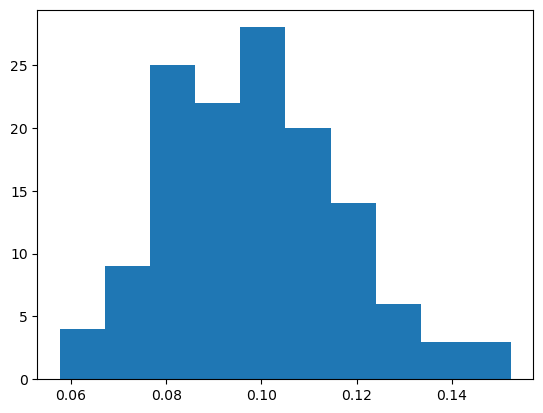

In [19]:
losses = []
with torch.no_grad():
    for instance in evaluation_instances:
        x = heu.gen_x(instance).T
        y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
        if len(y) == 0:
            continue
        y_pred = heu.net(x)
        eval_loss = heu.criterion(y,y_pred)
        losses.append(eval_loss)
precision = (1-np.average(losses))*100
desviacion_estandar = (np.std(losses))*100
print(f"Presicion {np.round(precision,3)}%")
print(f"STD {np.round(desviacion_estandar,3)}%")

plt.hist(losses)